In [2]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from helpers.cm26 import DatasetCM26
from helpers.selectors import select_NA, select_Pacific, select_Cem, select_globe, compare, plot
from helpers.operators import Coarsen, Filtering, Subsampling, CoarsenKochkov, CoarsenWeighted

import hvplot.xarray
import hvplot
import cmocean

%load_ext autoreload
%autoreload 3

In [3]:
ds = xr.open_dataset("gs://cmip6/GFDL_CM2_6/control/ocean_3d", engine='zarr', chunks={}, use_cftime=True)
param = xr.open_dataset("gs://cmip6/GFDL_CM2_6/grid", engine='zarr')

In [4]:
import gsw

# Computing Nsquared
The Nsquared interface requires:
* Absolute Salinity, g/kg
* Conservative Temperature (ITS-90), degrees C
* Sea pressure (absolute pressure minus 10.1325 dbar), dbar

The CM2.6 dataset provides:
* Potential temperature, degrees C
* Practical Salinity, psu

In [5]:
SP = ds['salt'] # Practical salinity
PT = ds['temp'] # Potential temperature

In [6]:
# Note that we pass the negative depth because the axis is upward in this function
# The output is almost similar to depth in metres
P = gsw.p_from_z(-param.st_ocean, param.yt_ocean).chunk() # sea pressure ( i.e. absolute pressure - 10.1325 dbar )

In [7]:
Z = param.st_ocean.expand_dims({'yt_ocean': param.yt_ocean})

Text(0, 0.5, 'Sea pressure in dbar')

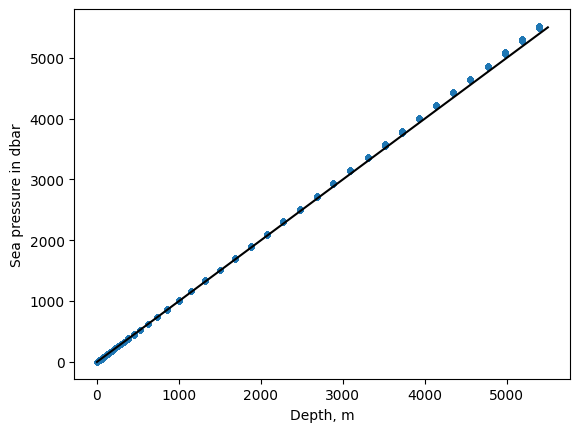

In [13]:
plt.plot(Z.values.ravel(),P.T.values.ravel(), '.');
plt.plot([0,5500],[0,5500],'k')
plt.xlabel('Depth, m')
plt.ylabel('Sea pressure in dbar')

In [8]:
# Note here we provide longitude in a range -280..80, and it is OK. We
# still can target Baltic sea, which is a purpose of this input parameter
# The output is almost similar to Practical Salinity
SA = gsw.SA_from_SP(SP, P, param.xt_ocean, param.yt_ocean) # Absolute Salinity

Text(0, 0.5, 'Absolute Salinity, g/kg')

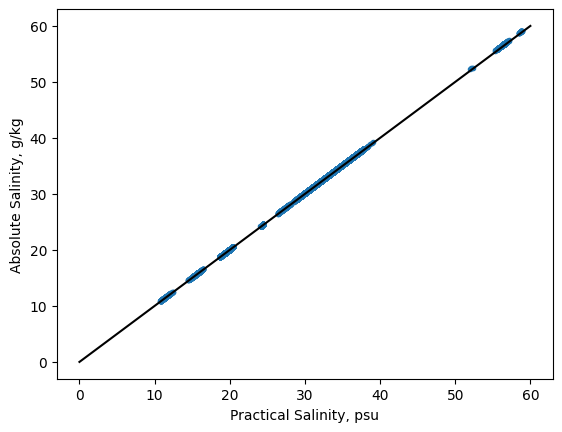

In [18]:
plt.plot(SP[0][10].values.ravel(), SA[0][10].values.ravel(), '.')
plt.plot([0,60], [0,60], 'k')
plt.xlabel('Practical Salinity, psu')
plt.ylabel('Absolute Salinity, g/kg')

In [9]:
# Note the output is almost identical
CT = gsw.CT_from_pt(SA, PT) # Conservative temperature, in degrees

Text(0, 0.5, 'Conservative Temperature, C')

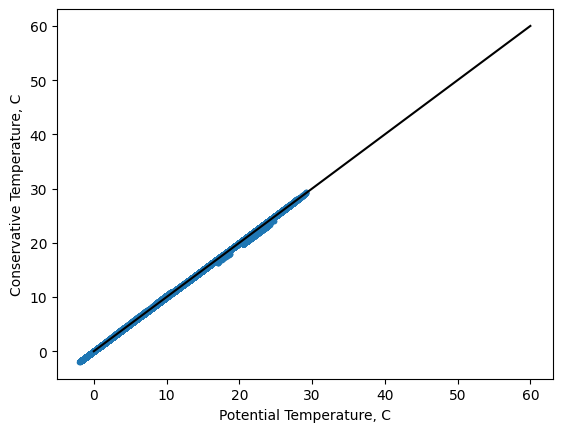

In [22]:
plt.plot(PT[0][10].values.ravel(), CT[0][10].values.ravel(), '.')
plt.plot([0,60], [0,60], 'k')
plt.xlabel('Potential Temperature, C')
plt.ylabel('Conservative Temperature, C')

# Check vertical profile

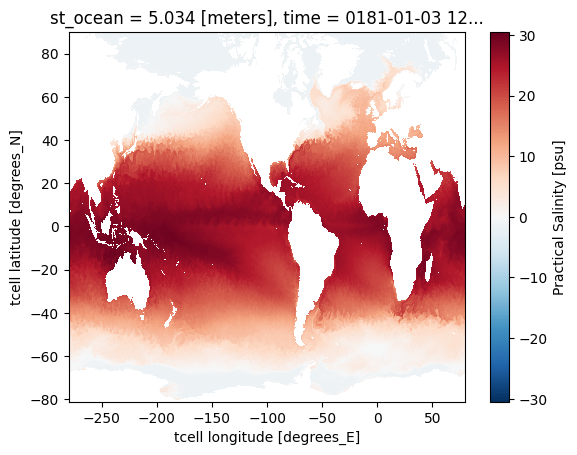

In [48]:
CT[0][0].plot()

In [10]:
def select(x):
    y=x
    if 'xt_ocean' in x.dims:
        y = y.sel(xt_ocean=-149.95, method='nearest')
    if 'yt_ocean' in x.dims:
        y = y.sel(yt_ocean=0.0, method='nearest')

    if 'time' in x.dims:
        y = y.isel(time=0)
    return y

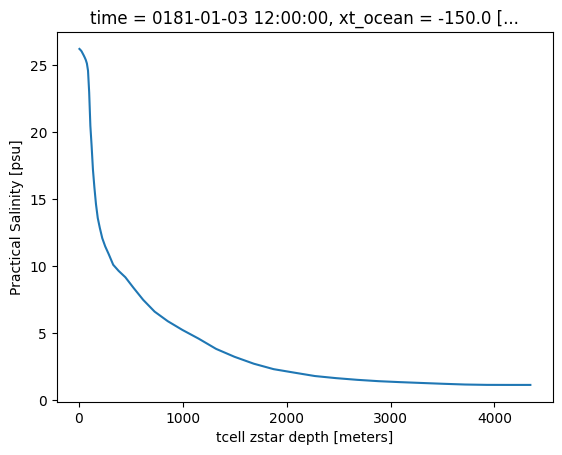

In [11]:
select(CT).plot()

In [12]:
N2 = gsw.Nsquared(select(SA), select(CT), select(P), axis=0)

In [13]:
# So the only vertical coordinate used here is the sea level pressure in dbars
N2_val = gsw.Nsquared(select(SA).values, select(CT).values, select(P).values, axis=0)

In [14]:
(N2_val[0]-N2[0])

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., nan, nan, nan, nan, nan])

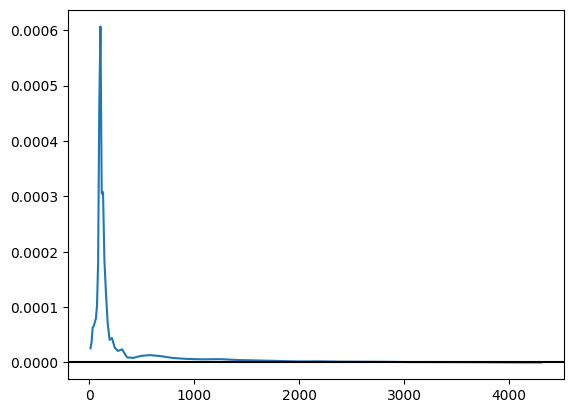

In [15]:
plt.plot(N2[1], N2[0])
plt.axhline(y=0, color='k')

# In-situ density calculated with zero pressure is the potential density

In [16]:
rho = gsw.rho(select(SA), select(CT), select(P))
rho0 = gsw.rho(select(SA), select(CT), 0.)
rho_lazy = gsw.rho(select(SP), select(PT), 0.)
sigma0p = (1000.+gsw.sigma0(select(SA), select(CT)))

In [17]:
(rho0-sigma0p).values

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., nan, nan, nan, nan, nan])

In [18]:
(rho_lazy-sigma0p).values

array([-0.12197591, -0.12209987, -0.12238848, -0.12296153, -0.12359271,
       -0.12430327, -0.12505459, -0.12591813, -0.12713057, -0.12925056,
       -0.1308847 , -0.13127159, -0.1314391 , -0.13130373, -0.13079422,
       -0.13021478, -0.12995158, -0.12988835, -0.1298882 , -0.12991301,
       -0.13009341, -0.13035144, -0.13074894, -0.13127981, -0.13216479,
       -0.13327509, -0.13442962, -0.13561363, -0.13686913, -0.13821694,
       -0.13949545, -0.14031922, -0.14101364, -0.14156824, -0.14205964,
       -0.14236231, -0.1425869 , -0.14273182, -0.14279102, -0.14280134,
       -0.14277095, -0.14269629, -0.14256094, -0.14240477, -0.14223143,
               nan,         nan,         nan,         nan,         nan])

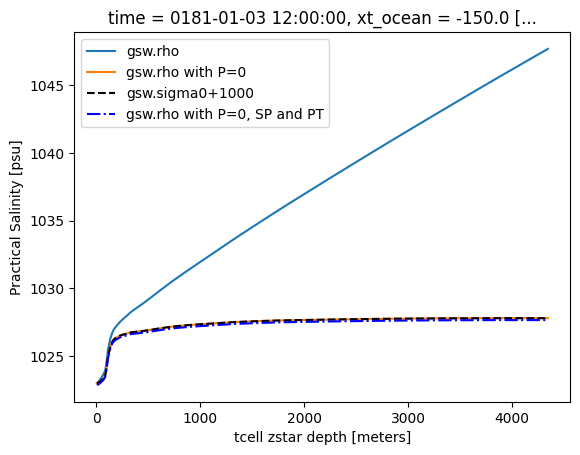

In [19]:
rho.plot(label='gsw.rho')
rho0.plot(label='gsw.rho with P=0')
sigma0p.plot(label='gsw.sigma0+1000', ls='--', color='k')
rho_lazy.plot(label='gsw.rho with P=0, SP and PT', ls='-.', color='b')
plt.legend()

In [20]:
drhodz = rho_lazy.chunk({'st_ocean':-1}).differentiate('st_ocean')
N2_lazy = (9.8*drhodz/1025)

drhodz = rho_lazy.chunk({'st_ocean':-1}).diff('st_ocean') / rho_lazy.st_ocean.diff('st_ocean')
drhodz['st_ocean'] = rho_lazy.st_ocean.rolling(st_ocean=2).mean()[1:]
N2_FD = (9.8*drhodz/1025)

drhodz = sigma0p.chunk({'st_ocean':-1}).diff('st_ocean') / select(P).diff('st_ocean')
drhodz['st_ocean'] = select(P).rolling(st_ocean=2).mean()[1:]
N2_accurate = (9.8*drhodz/1025)

drhodz = sigma0p.chunk({'st_ocean':-1}).diff('st_ocean') / select(P).diff('st_ocean')
drhodz['st_ocean'] = select(P).rolling(st_ocean=2).mean()[1:]
N2_accurate2 = (9.7963*drhodz/1025) # Value of g is from https://www.teos-10.org/pubs/gsw/html/gsw_Nsquared.html

drhodz = sigma0p.chunk({'st_ocean':-1}).diff('st_ocean') / select(P).diff('st_ocean')
drhodz['st_ocean'] = select(P).rolling(st_ocean=2).mean()[1:]
N2_accurate3 = 9.7963*drhodz/sigma0p.rolling(st_ocean=2).mean()[1:].drop_vars('st_ocean')

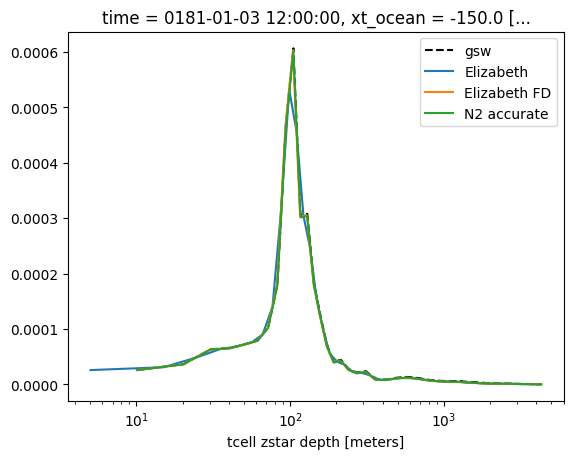

In [21]:
plt.plot(N2[1], N2[0], ls='--', label='gsw', color='k')
N2_lazy.plot(label='Elizabeth')
N2_FD.plot(label='Elizabeth FD')
N2_accurate.plot(label='N2 accurate')
plt.xscale('log')
plt.legend()

In [22]:
np.nanmean((N2[0]-N2_FD.values)**2)

1.3553284829440233e-12

In [23]:
np.nanmean((N2[0]-N2_accurate.values)**2)

2.6983518569707043e-12

In [24]:
np.nanmean((N2[0]-N2_accurate2.values)**2)

2.8529452714523265e-12

In [25]:
np.nanmean((N2[0]-N2_accurate3.values)**2)

2.7975598594687857e-12

## Conclusions of this study on TEOS-10:
* New variables for temperature, salinity and pressure (close to depth) do not change significantly prediction of density
* The most impact is oserved for considering in-situ vs conservative density. sigma0 is the potential density which should be used for N2 computation
* Reference values for g and density used by Elizabeth without conversion of T,S,P are more accurate then any other empirical formulas for N2.

# Including Nsquared computations into CM26 dataset structure

In [26]:
%%time 
ds = DatasetCM26(source='cmip6-3d')

CPU times: user 28.2 s, sys: 10.4 s, total: 38.5 s
Wall time: 28.1 s


In [26]:
# coarse = ds.coarsen()

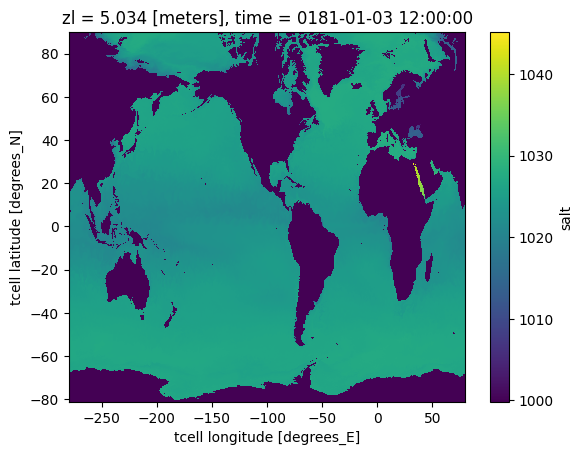

In [27]:
ds.state.rho.isel(time=0,zl=0).plot()

In [132]:
%%time 
test = select(ds.state.Nsquared.rename({'xh': 'xt_ocean', 'yh': 'yt_ocean'})).compute()

CPU times: user 24.9 s, sys: 9.17 s, total: 34.1 s
Wall time: 19.8 s


In [133]:
(test[1:-1].values-N2_FD.values)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., nan, nan, nan, nan, nan])

In [125]:
%time cg = ds.state.baroclinic_speed.isel(time=0).compute();

CPU times: user 27.7 s, sys: 11.2 s, total: 38.9 s
Wall time: 24.5 s


In [134]:
%time Rd = ds.state.deformation_radius.isel(time=0).compute()

CPU times: user 27.4 s, sys: 11.3 s, total: 38.7 s
Wall time: 24.3 s


Text(0.5, 1.0, 'Rossby deformation radius in km')

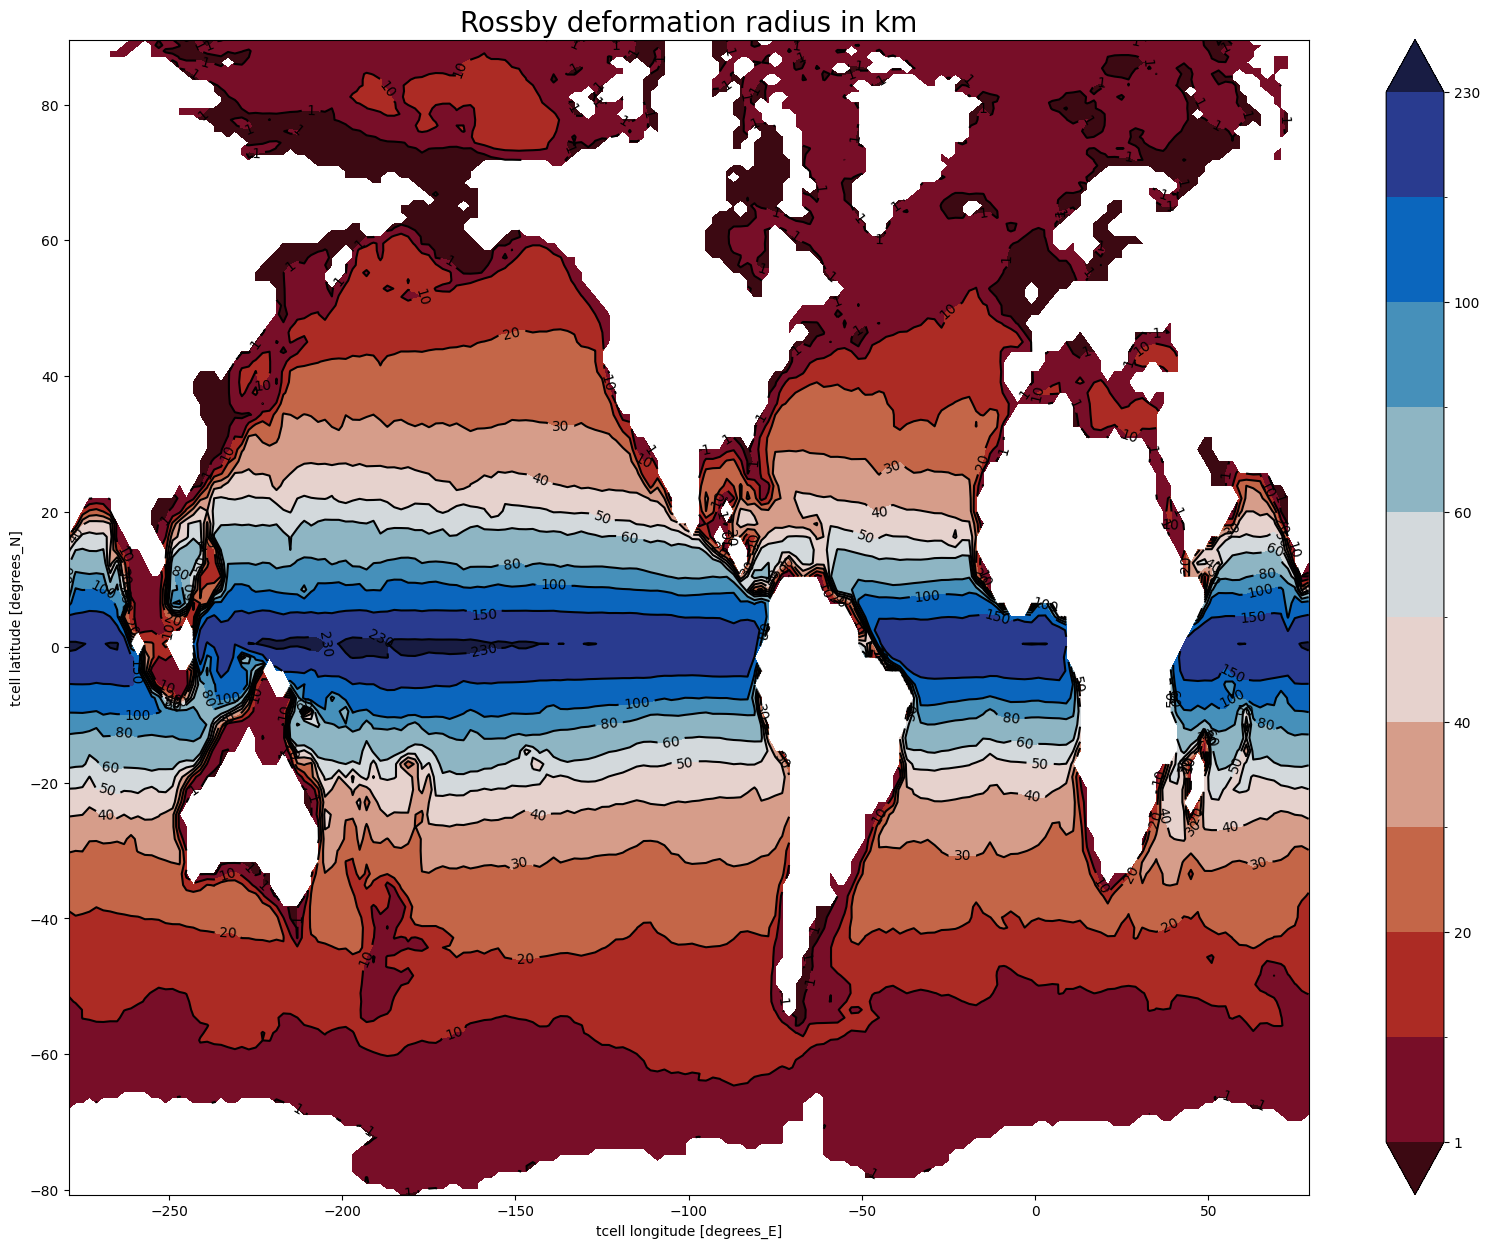

In [135]:
plt.figure(figsize=(20,15))
import cmocean
mask = ds.param.wet[0]
mask = np.where(mask,1,np.nan)

Rdc = (Rd*1e-3*mask).coarsen({'xh':20, 'yh':20}).mean()

(Rdc).plot.contourf(levels=[1,10, 20, 30, 40, 50, 60, 80, 100, 150, 230], cmap=cmocean.cm.balance.reversed(),extend='both')
CS = (Rdc).plot.contour(levels=[1,10, 20, 30, 40, 50, 60, 80, 100, 150, 230], colors='k')
plt.clabel(CS)
plt.title('Rossby deformation radius in km', fontsize=20)

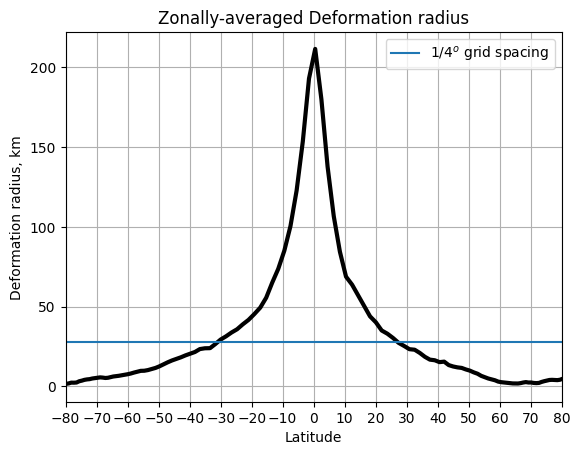

In [136]:
Rdc.mean('xh').plot(color='k', lw=3)
plt.ylabel('Deformation radius, km')
plt.xlabel('Latitude')
plt.title('Zonally-averaged Deformation radius')
plt.xticks(np.arange(-80,100,10));
plt.xlim([-80, 80])
dx = 40000/360/4 # of 1/4 degree model
plt.axhline(y=dx, color='tab:blue', label='$1/4^o$ grid spacing')
plt.grid()
plt.legend()

In [32]:
%time Rd_dx = ds.state.Rd_dx.isel(time=0).compute()

CPU times: user 27.4 s, sys: 11.4 s, total: 38.8 s
Wall time: 24.1 s


Text(0.5, 1.0, 'Rossby deformation radius divided by the grid step for CM2.6')

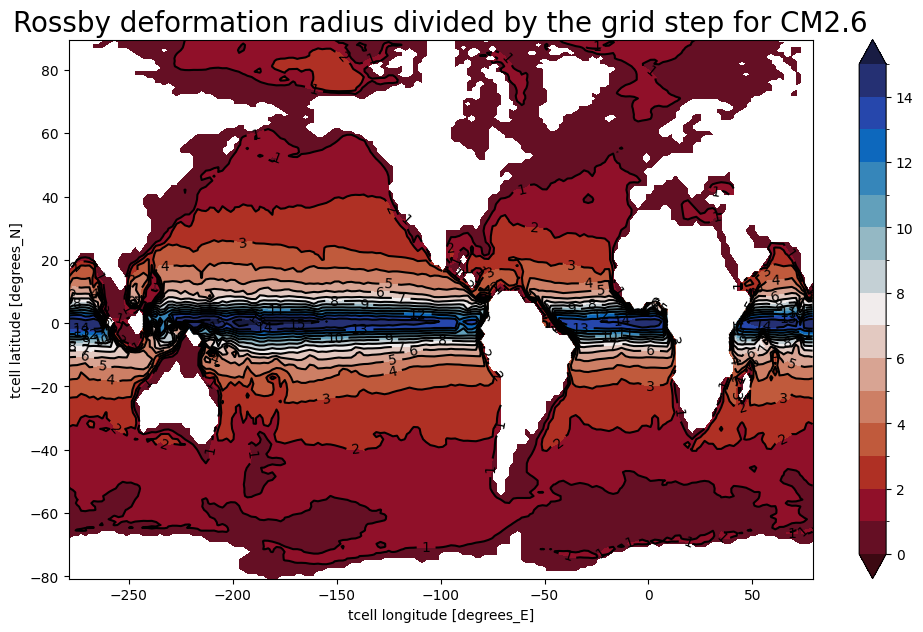

In [33]:
plt.figure(figsize=(12,7))
import cmocean
mask = ds.param.wet[0]
mask = np.where(mask,1,np.nan)

Rdc = (Rd_dx*mask).coarsen({'xh':20, 'yh':20}).mean()

(Rdc).plot.contourf(levels=np.arange(0,16), cmap=cmocean.cm.balance.reversed(),extend='both')
CS = (Rdc).plot.contour(levels=np.arange(0,16), colors='k')
plt.clabel(CS)
plt.title('Rossby deformation radius divided by the grid step for CM2.6', fontsize=20)

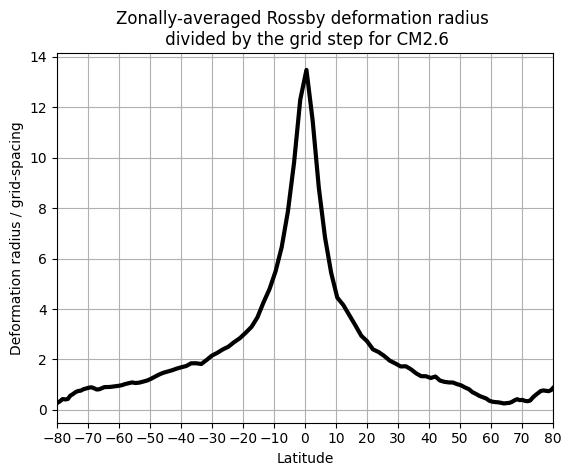

In [34]:
Rdc.mean('xh').plot(color='k', lw=3)
plt.ylabel('Deformation radius / grid-spacing')
plt.xlabel('Latitude')
plt.title('Zonally-averaged Rossby deformation radius \n divided by the grid step for CM2.6')
plt.xticks(np.arange(-80,100,10));
plt.xlim([-80, 80])
plt.grid()

In [35]:
Ro = ds.state.rossby_number.isel(time=0).compute()

In [36]:
mask = np.where(ds.param.wet,1,np.nan)
ro = (Ro  * mask).coarsen({'xh': 5, 'yh': 5}).mean().compute()

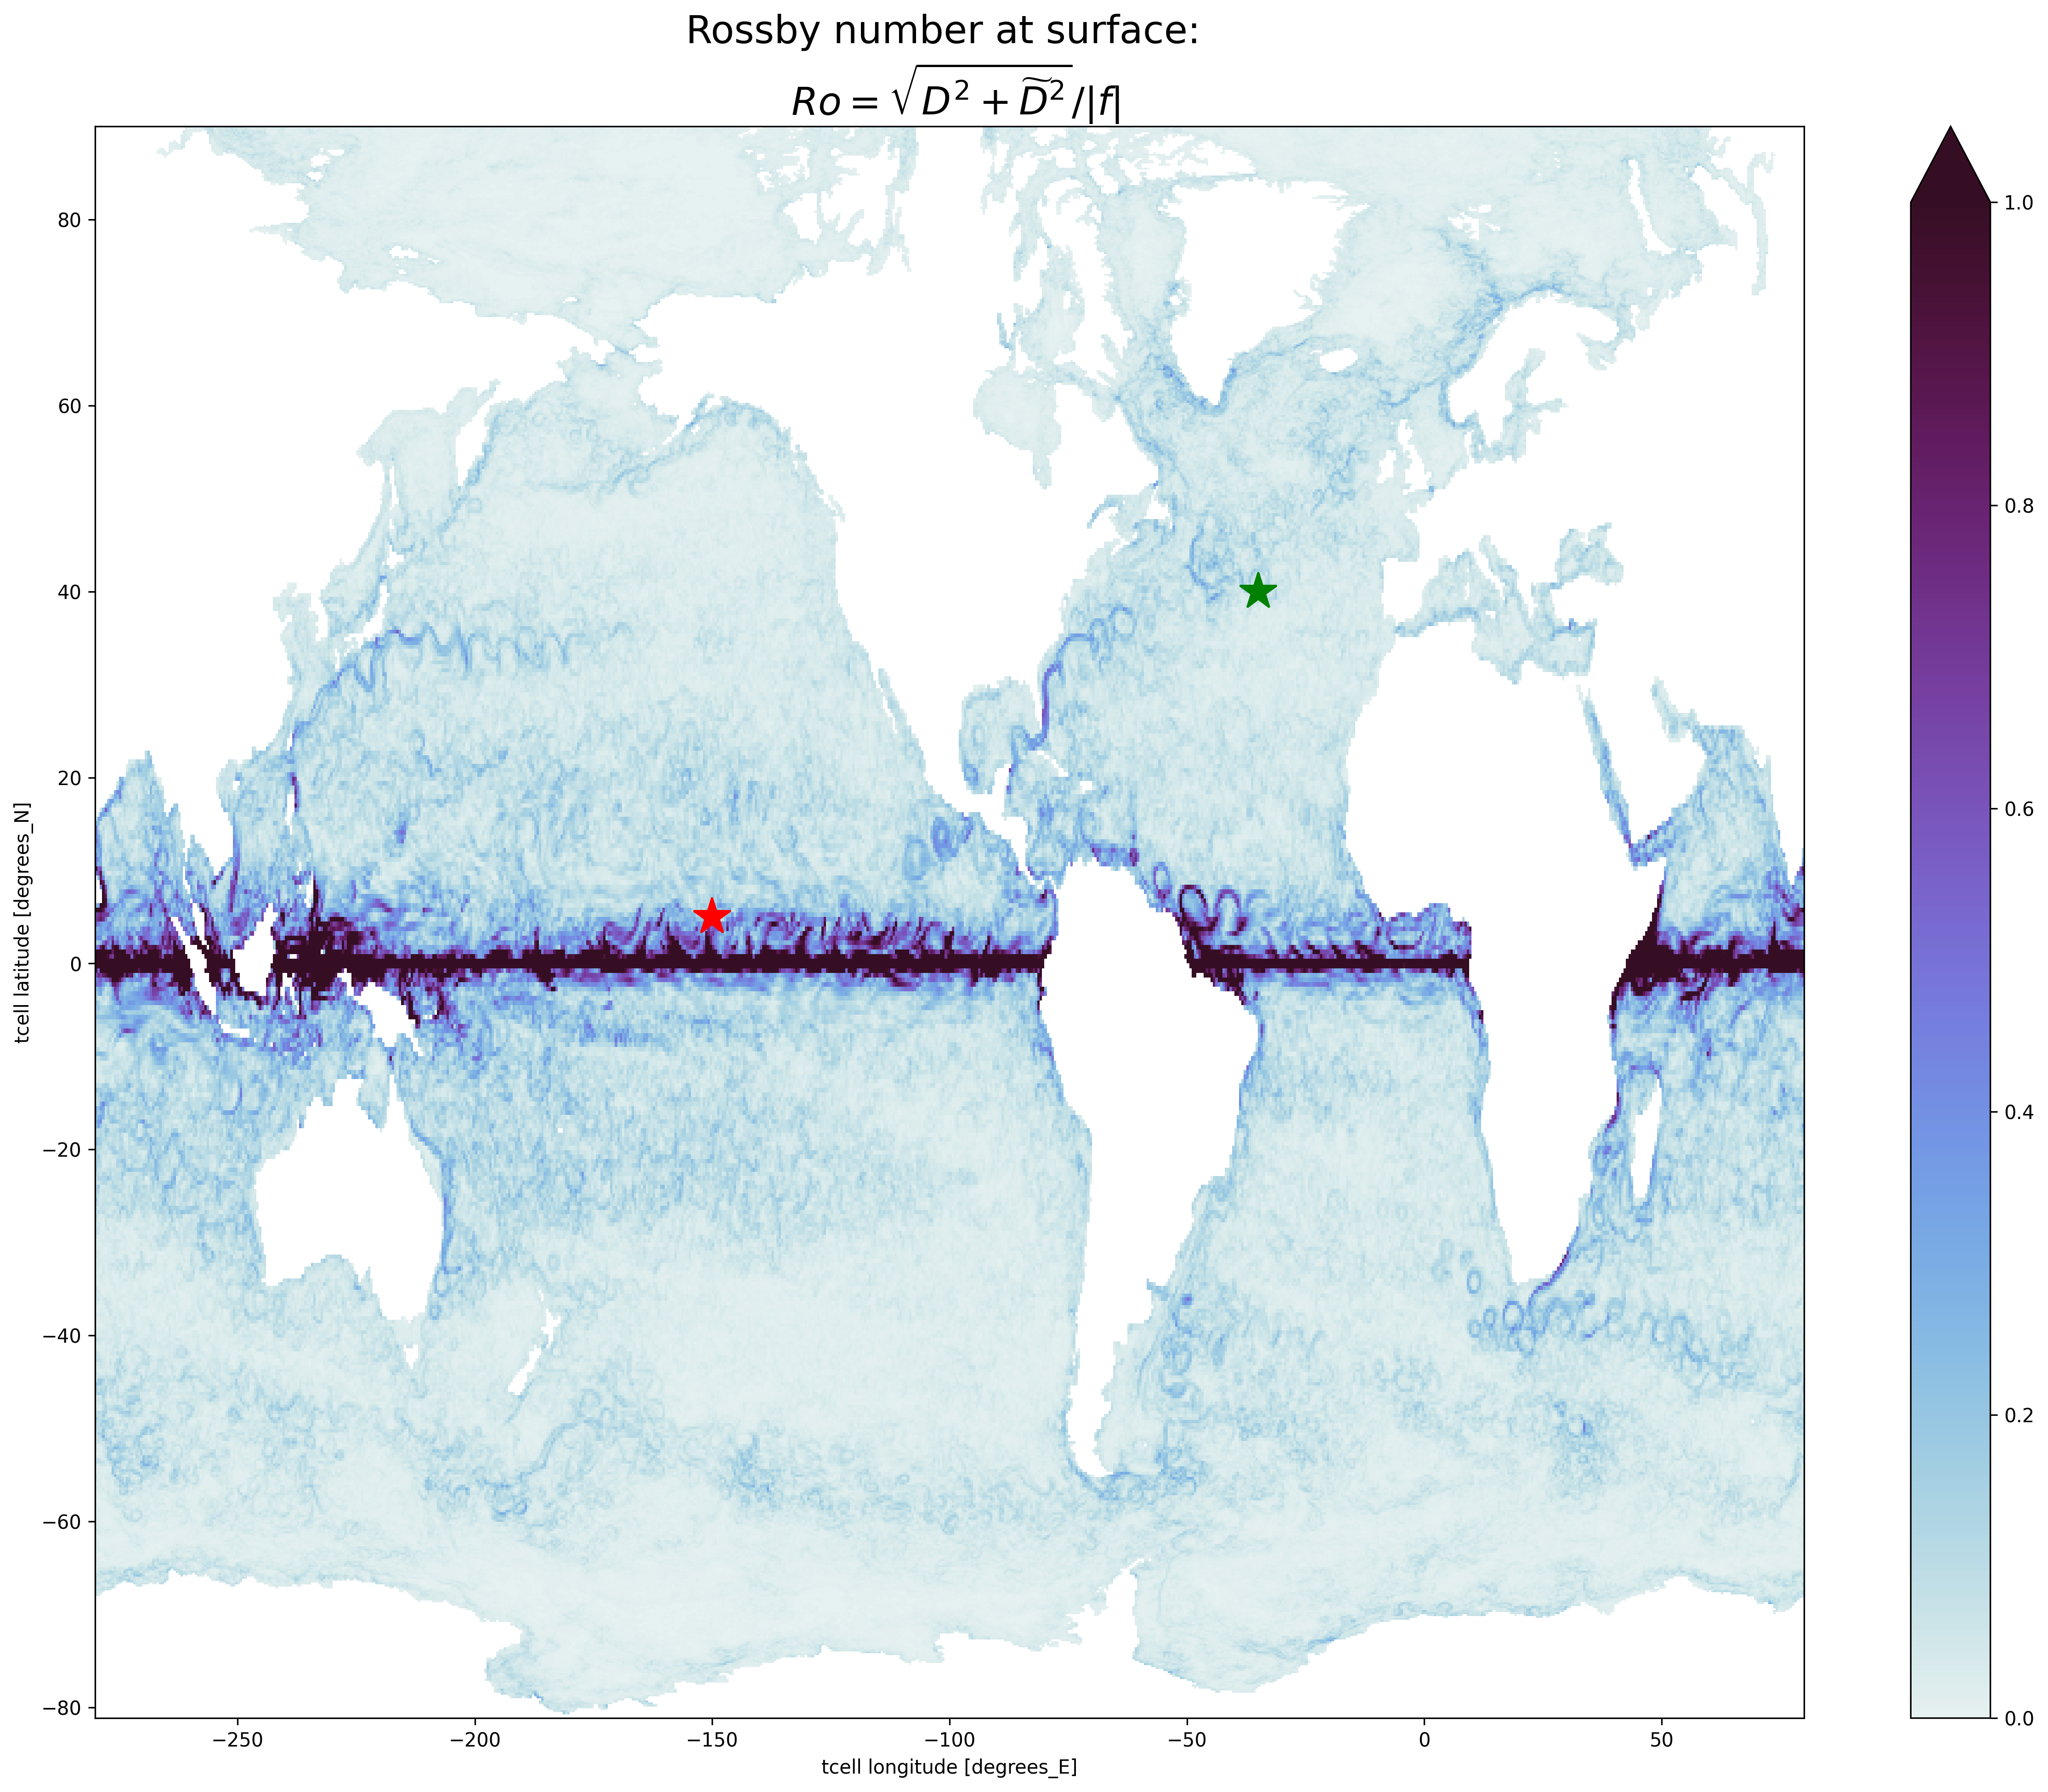

In [37]:
plt.figure(figsize=(20,15), dpi=300)
ro.isel(zl=0).plot(cmap=cmocean.cm.dense, vmax=1)
plt.title('Rossby number at surface: \n $Ro=\sqrt{D^2+\widetilde{D}^2} / |f|$', fontsize=20)
plt.plot(-35,40, '*g',markersize=20)
plt.plot(-150,5, '*r',markersize=20)

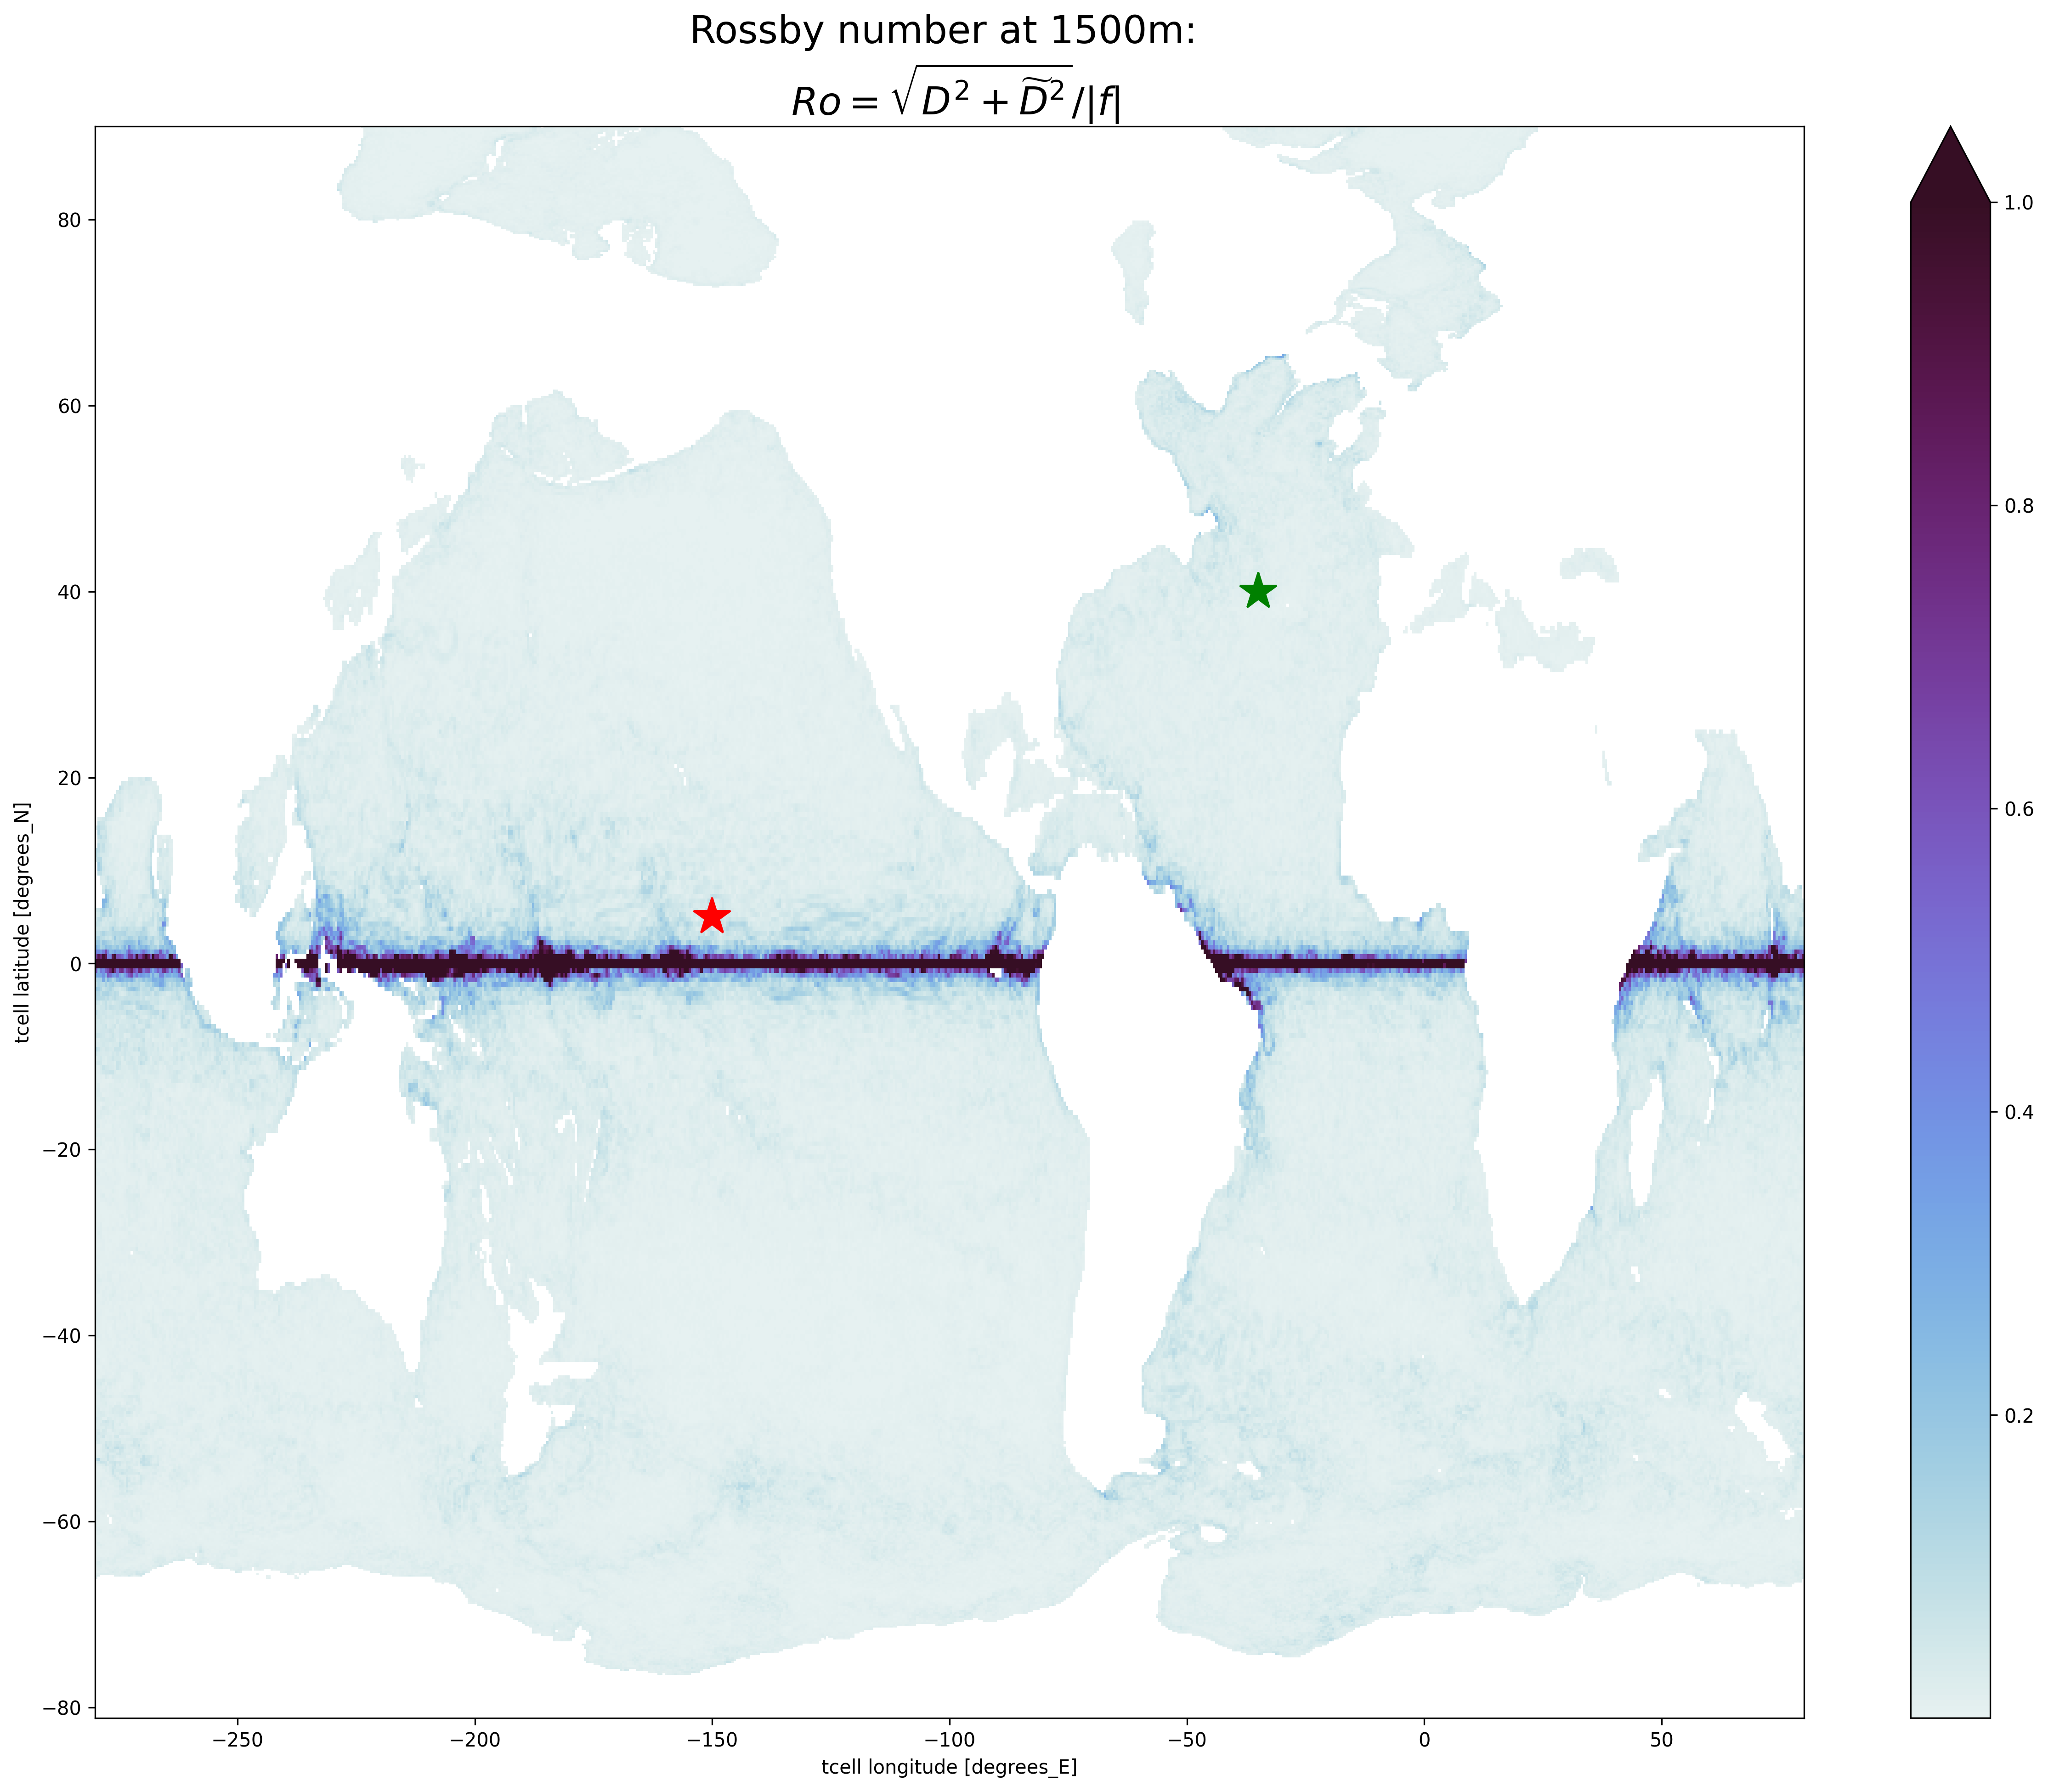

In [38]:
plt.figure(figsize=(20,15), dpi=300)
ro.isel(zl=30).plot(cmap=cmocean.cm.dense, vmax=1)
plt.title('Rossby number at 1500m: \n $Ro=\sqrt{D^2+\widetilde{D}^2} / |f|$', fontsize=20)
plt.plot(-35,40, '*g',markersize=20)
plt.plot(-150,5, '*r',markersize=20)

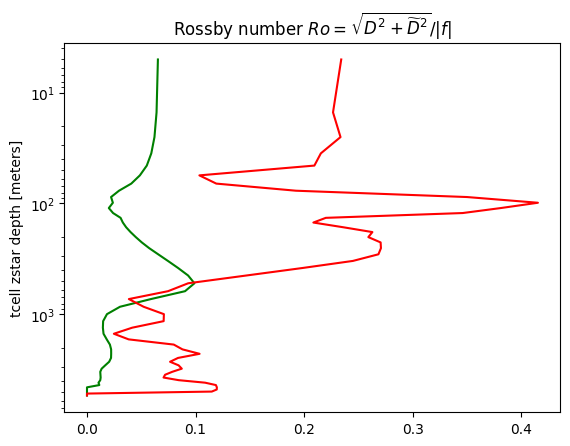

In [39]:
Ro.sel(xh=-35, yh=40, method='nearest').plot(color='g', y='zl')
Ro.sel(xh=-150, yh=5, method='nearest').plot(color='r', y='zl')
plt.title('Rossby number $Ro=\sqrt{D^2+\widetilde{D}^2} / |f|$')
plt.gca().invert_yaxis()
plt.yscale('log')

In [40]:
rr = (Ro * mask).values.ravel()
rr = rr[~np.isnan(rr)];

Text(0.5, 0, 'Ro')

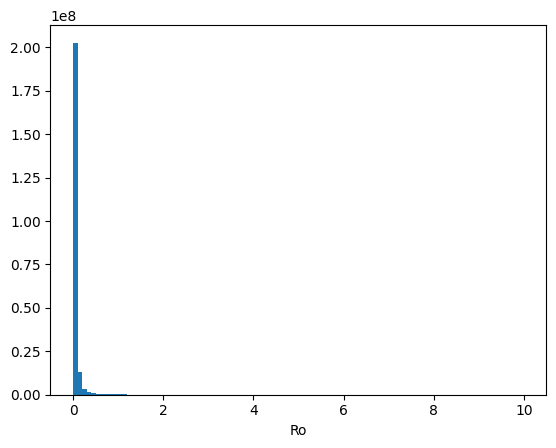

In [41]:
plt.hist(rr, bins=100, range=[0,10]);
#plt.yscale('log')
plt.xlabel('Ro')

Text(0.5, 0, '1/(1+Ro)')

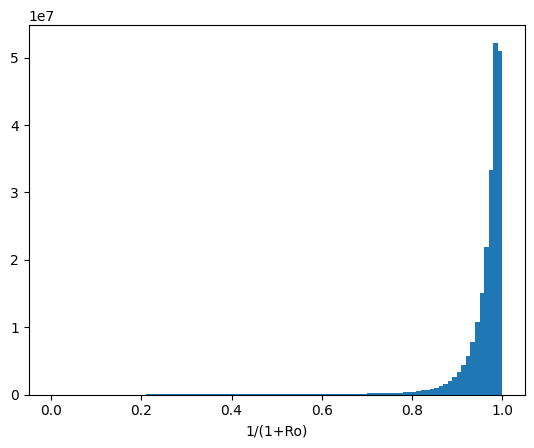

In [42]:
plt.hist(1/(1+rr), bins=100, range=[0,1]);
#plt.yscale('log')
plt.xlabel('1/(1+Ro)')

Text(0.5, 0, 'log10(Ro)')

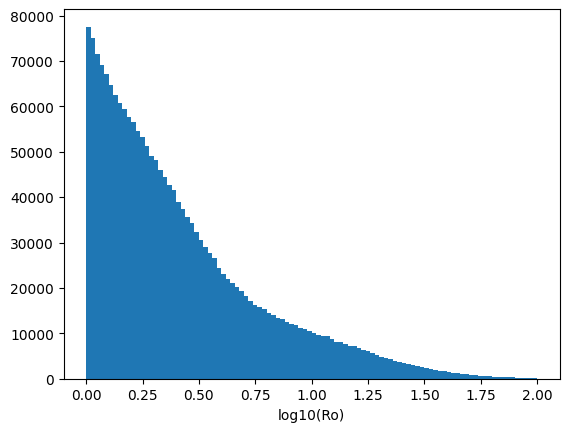

In [43]:
plt.hist(np.log10(rr), bins=100, range=[0,2]);
plt.xlabel('log10(Ro)')

# Vertical grid
Here we show that cell interfaces are located exactly between cell centers, but not vise versa:
\begin{equation}
    z_{k+1/2} = \frac{z_k + z_{k+1}}{2}
\end{equation}
Note that the vertical coordinate in MOM6 is different: it is center cells that are between interfaces:
\begin{equation}
    z_{k} = \frac{z_{k-1/2} + z_{k+1/2}}{2}
\end{equation}

Note that in both formulations of vertical coordinate, the xgcm.diff and xgcm.interp operator works as finite difference operators which do not account for the coordinates

In [45]:
zl = ds.param.zl
zi = ds.param.zi

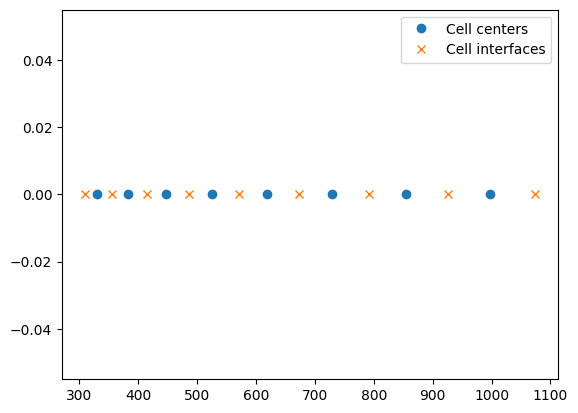

In [51]:
idxl = slice(20,26)
idxi = slice(20,27)
plt.plot(zl[idxl],0*zl[idxl], 'o', label='Cell centers')
plt.plot(zi[idxi],0*zi[idxi], 'x', label='Cell interfaces')
plt.legend()

In [75]:
zl.rolling(zl=2).mean().values - zi[:-1].values

array([            nan,  2.38418579e-07,  4.76837158e-07,  9.53674316e-07,
        1.90734863e-06, -1.90734863e-06,  0.00000000e+00, -3.81469727e-06,
       -3.81469727e-06,  3.81469727e-06,  0.00000000e+00,  0.00000000e+00,
        3.81469727e-06, -7.62939453e-06, -7.62939453e-06,  0.00000000e+00,
        0.00000000e+00,  7.62939453e-06,  0.00000000e+00, -1.52587891e-05,
        0.00000000e+00,  0.00000000e+00,  1.52587891e-05, -1.52587891e-05,
        0.00000000e+00,  3.05175781e-05,  3.05175781e-05,  3.05175781e-05,
        3.05175781e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -6.10351562e-05,  0.00000000e+00,  0.00000000e+00,
       -1.22070312e-04, -1.22070312e-04,  0.00000000e+00,  0.00000000e+00,
       -1.22070312e-04,  0.00000000e+00,  0.00000000e+00, -1.22070312e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [76]:
zi.rolling(zi=2).mean()[1:].values - zl.values

array([0.00000000e+00, 1.28998756e-02, 5.09929657e-03, 1.96981430e-02,
       1.47495270e-02, 3.29017639e-02, 3.31516266e-02, 5.82542419e-02,
       6.80503845e-02, 1.06647491e-01, 1.34399414e-01, 1.97849274e-01,
       2.59048462e-01, 3.67263794e-01, 4.87899780e-01, 6.72950745e-01,
       8.90945435e-01, 1.19414520e+00, 1.54795837e+00, 1.99356079e+00,
       2.47509766e+00, 3.00099182e+00, 3.47369385e+00, 3.86616516e+00,
       4.06704712e+00, 4.07809448e+00, 3.85504150e+00, 3.48474121e+00,
       2.98992920e+00, 2.48614502e+00, 1.98254395e+00, 1.55889893e+00,
       1.18322754e+00, 9.01916504e-01, 6.62109375e-01, 4.98657227e-01,
       3.56811523e-01, 2.69653320e-01, 1.87377930e-01, 1.44653320e-01,
       9.68017578e-02, 7.78808594e-02, 4.83398438e-02, 4.34570312e-02,
       2.24609375e-02, 2.51464844e-02, 9.52148438e-03, 1.51367188e-02,
       2.68554688e-03, 1.04980469e-02])

In [77]:
grid = ds.grid

In [82]:
grid.diff(zi,'Z') - np.diff(zi)

<xarray.DataArray 'zi' (zl: 50)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Coordinates:
  * zl       (zl) float64 5.034 15.1 25.22 ... 4.975e+03 5.185e+03 5.395e+03

In [97]:
grid.interp(zi,'Z').values - (zi).rolling(zi=2).mean()[1:].values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [90]:
grid.diff(zl,'Z')[1:-1] - np.diff(zl)

<xarray.DataArray 'zl' (zi: 49)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Coordinates:
  * zi       (zi) float64 10.07 20.16 30.29 40.47 ... 4.87e+03 5.08e+03 5.29e+03

In [99]:
grid.interp(zi,'Z').values - (zi).rolling(zi=2).mean()[1:].values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [110]:
grid.interp(zl,'Z')[1:-1].values - zl.rolling(zl=2).mean()[1:].values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])